Model, gaz kelebeği girişlerini kabul eder ve uzunlamasına dinamik denklemlerden geçer. Modelin girdisi bir gaz kelebeği yüzdesidir $x_\theta \in [0,1]$Bu, motora tork sağlar ve ardından aracı ileri hareket için hızlandırır. 
Dinamik denklemler, gaz kelebeği girişlerini tekerlek hızına dönüştürmek için birçok aşamadan oluşur (motor -> tork konvertörü -> şanzıman -> tekerlek). Bu aşamalar tek bir eylemsizlik terimi içinde bir araya getirilmiştir. $J_e$Aşağıdaki kombine motor dinamiği denklemlerinde kullanılır. 

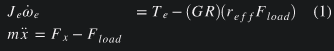

$T_e$ : motor torku, $GR$ : dişli oranı, $r_{eff}$ : etkili yarıçap, $m$ : araç kütlesi $x$ : araç konumu, $F_x$ : lastik kuvveti, $F_{load}$ : toplam yük kuvvetidir.

Motor torku, gaz kelebeği girişinden ve motor açısal hızından hesaplanır.
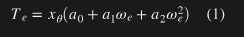

Yük kuvvetleri aerodinamik sürüklemeden oluşur $F_{aero}$, yuvarlanma sürtünmesi $R_x$ ve yerçekimi kuvveti $F_g$ açıda bir eğimden $\alpha$. Aerodinamik sürükleme ikinci dereceden bir modeldir ve sürtünme doğrusal bir modeldir. 

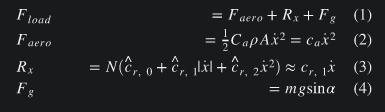

Model yalnızca ileri hareket için kullanıldığından, mutlak değerin sürtünme için ihmal edildiğine dikkat edin ( $\dot{x} \ge 0$).

Lastik kuvveti, motor devri ve tekerlek kayma denklemleri kullanılarak hesaplanır:

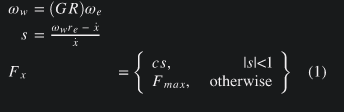

$\omega_w$ tekerlek açısal hızı ve $s$ kayma oranıdır. 

Boylamsal modeli aşağıdaki bir Python sınıfı içinde kuruyoruz. Araç, 5 m / s'lik bir başlangıç ​​hızı ve 100 rad / s'lik motor hızı ile başlar. İlgili tüm parametreler tanımlanır ve bisiklet modeli gibi, sayısal entegrasyon için 10 ms'lik bir örnekleme süresi kullanılır. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

In [2]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        # ==================================
        #  Implement vehicle model here
        # ==================================
        T_e = throttle * (self.a_0 + self.a_1*self.w_e + self.a_2*self.w_e**2)
        F_areo = self.c_a * self.v**2
        R_x = self.c_r1 * self.v
        F_g = self.m * self.g * np.sin(alpha)
        F_load = F_areo + R_x + F_g
        #torque equation (angular acceleration)
        self.w_e_dot = (T_e - self.GR*self.r_e*F_load) / self.J_e
        
        w_w = self.GR * self.w_e
        s = (w_w*self.r_e - self.v) / self.v
        if abs(s) < 1:
            F_x = self.c * s
        else:
            F_x = self.F_max
        #force equation (acceleration) 
        self.a = (F_x - F_load) / self.m
            
        #update equations
        self.w_e += self.w_e_dot * self.sample_time
        #since v = a*t
        self.v += self.a * self.sample_time
        #since x = v*t - (1/2)*a*t^2
        self.x += (self.v * self.sample_time) - (0.5 * self.a * self.sample_time**2)

Modeli kullanarak aşağıdaki hücrede bulunan araca sabit gaz kelebeği girişleri gönderebilirsiniz. Aerodinamik sürtünme ve lastik kuvveti sınırı nedeniyle gaz kelebeği girişine bağlı olarak hızın sabit bir değere yakınsayacaktır. Negatif bir eğim açısı $\alpha$ ayarlayarak benzer bir hız profili görülebilir. Bu durumda yerçekimi, aracı sürükleme kuvveti ile dengelendiği bir son hıza kadar hızlandırır. 

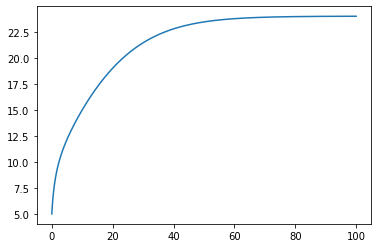

In [3]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.2

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    model.step(throttle, alpha)
    
plt.plot(t_data, v_data)
plt.show()

Şimdi aracı aşağıdaki şemada gösterildiği gibi bir yokuşta sürecek.

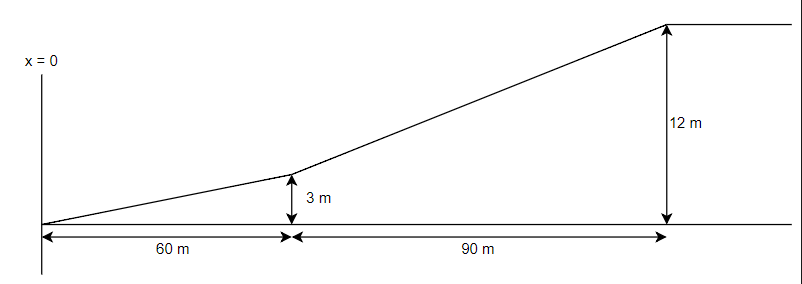

Eğimi tırmanmak için, aşağıdaki şekilde gösterildiği gibi sonraki 20 saniye boyunca bir gaz kelebeği girişi sağlanır. 

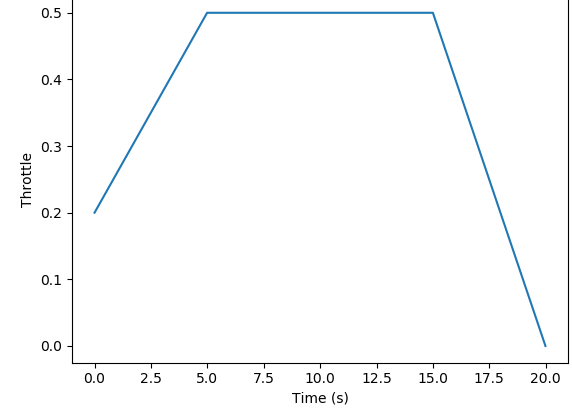

Araç %20 gaz kelebeği ile başlar ve kademeli olarak %50 gaz kelebeğine yükselir. Araç dik yokuşa tırmanırken bu 10 saniye boyunca korunur. Daha sonra araç gazı 0'a düşürür.

Aşağıdaki hücrede rampa açısı profilini uygulanacak $\alpha (x)$ ve gaz profili $x_\theta (t)$ ve onları araç dinamikleri boyunca ilerletilecek. Araç konumu $x(t)$ diziye kaydedilir $\textit{x_data}$.

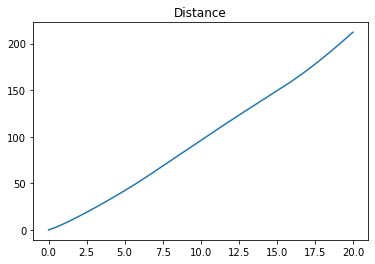

In [4]:
time_end = 20
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_e_data = np.zeros_like(t_data)

# reset the states
model.reset()

# ==================================
#  Learner solution begins here
# ==================================
def angle(i, alpha, x):
    if x < 60:
        alpha[i] = np.arctan(3/60)
    elif x < 150:
        alpha[i] = np.arctan(9/90)
    else:
        alpha[i] = 0

throttle = np.zeros_like(t_data)
alpha = np.zeros_like(t_data)

#throttle depends on time and alpha depends on distance travelled (model.x)
for i in range(t_data.shape[0]):
    if t_data[i] < 5:
        throttle[i] = 0.2 + ((0.5 - 0.2)/5)*t_data[i]
        angle(i, alpha, model.x)
    elif t_data[i] < 15:
        throttle[i] = 0.5
        angle(i, alpha, model.x)
    else:
        throttle[i] = ((0 - 0.5)/(20 - 15))*(t_data[i] - 20)
        angle(i, alpha, model.x)
    
    #call the step function and update x_data array
    model.step(throttle[i], alpha[i])
    x_data[i] = model.x
    v_data[i] = model.v
    w_e_data[i] = model.w_e
     
# ==================================
#  Learner solution ends here
# ==================================

# Plot x vs t for visualization
plt.title('Distance')
plt.plot(t_data, x_data)
plt.show()

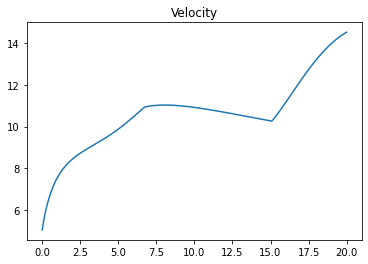

In [5]:
plt.title('Velocity')
plt.plot(t_data, v_data)
plt.show()

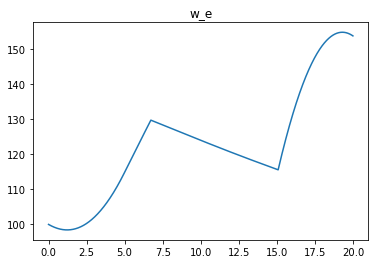

In [6]:
plt.title('w_e')
plt.plot(t_data, w_e_data)
plt.show()

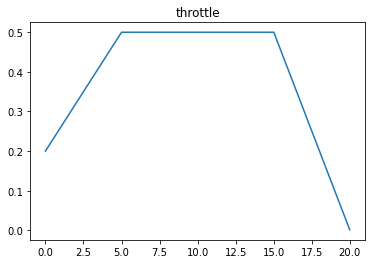

In [7]:
plt.title('throttle')
plt.plot(t_data, throttle)
plt.show()

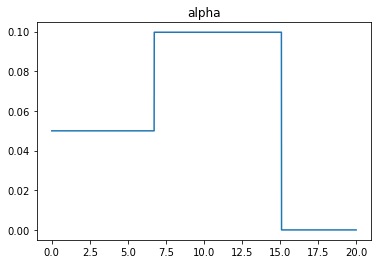

In [8]:
plt.title('alpha')
plt.plot(t_data, alpha)
plt.show()